In [1]:
from collections import Counter
import datetime
import gzip
import pathlib

import matplotlib.pyplot as plt
import numpy
import scipy
from scipy import ndimage

%matplotlib inline

In [2]:
class ParticleAnalysis:
    """Performs particle analysis of image data.
    
    Parameters
    ----------
    file_path: str
        Path to the image data.
    z_threshold: float
        Flat cutoff for data in z dimension.
    x_width_nm: float
        Width of x dimension of image in nanometres.
    """

    def __init__(self, file_path, z_threshold=0, x_width_nm=40_000):
        print('Loading data from "{}"...'.format(file_path))
        start_time = datetime.datetime.now()
        self._z_threshold = z_threshold
        self.header, raw_data_col = self.load_file_as_numpy_array(file_path)
        self.raw_data = numpy.reshape(raw_data_col, (-1, 4096))[::-1]
        x, _ = self.dimensions
        self.x_width_nm = x_width_nm
        self.area_per_pixel = (self.x_width_nm / x) ** 2
        data = self.raw_data > self._z_threshold
        self.clustered_data, self.cluster_num = scipy.ndimage.measurements.label(data)
        end_time = datetime.datetime.now()
        time_taken = end_time - start_time
        print("Data loaded in {} seconds.".format(time_taken.seconds))

    def __len__(self):
        return self.cluster_num

    @property
    def z_threshold(self):
        return self._z_threshold

    @z_threshold.setter
    def z_threshold(self, x):
        data = self.raw_data > x
        self.clustered_data, self.cluster_num = scipy.ndimage.measurements.label(data)
        self._z_threshold = x
        return

    @property
    def dimensions(self):
        """Calculated the x and y dimensions of the data.
        
        Returns
        -------
        dimensions: (int, int)
            Dimensions of the image data in pixels.
        
        Raises
        ------
        ValueError
            Returned if the data is not uniform in the x dimension.
        """
        row_lengths = {len(row) for row in self.raw_data}
        try:
            assert len(row_lengths) == 1
        except AssertionError:
            raise ValueError("Number of columns in data is not uniform.")
        return (len(self.raw_data), row_lengths.pop())

    def summary(self, min_area=0, max_area=None):
        """Generates a summary of the particle analysis.
        
        Parameters
        ----------
        min_area: float
            Minimum area of particles included in analysis. Default 0 nm^2.
        max_area: float
            Maximum area of particles included in analysis. Default None,
            includes all particles.
        
        Returns
        -------
        summary_dict: dict
            A dict containing a range of information regarding the particle
            analysis.
        """
        area_height_clusters = merge_cluster_dicts(
            self.get_cluster_areas(min_area, max_area),
            {k: v[2] for k, v in self.get_cluster_heights().items()},
        )
        p_areas = [x[0] for x in area_height_clusters.values()]
        p_diameters = [numpy.sqrt(x / numpy.pi) * 2 for x in p_areas]
        p_heights = [x[1] for x in area_height_clusters.values()]
        particle_count = len(area_height_clusters)
        dimensions = self.dimensions
        summary_dict = {
            "Total Particle Count": particle_count,
            "Density (per um^2)": particle_count
            * (1000 ** 2)
            / ((dimensions[0] * dimensions[1]) * self.area_per_pixel),
            "Particle Height (nm)": (
                numpy.mean(p_heights),
                numpy.min(p_heights),
                numpy.max(p_heights),
                numpy.std(p_heights),
            ),
            "Particle Area (nm^2)": (
                numpy.mean(p_areas),
                numpy.min(p_areas),
                numpy.max(p_areas),
                numpy.std(p_areas),
            ),
            "Particle Diameter (nm)": (
                numpy.mean(p_diameters),
                numpy.min(p_diameters),
                numpy.max(p_diameters),
                numpy.std(p_diameters),
            ),
        }
        return summary_dict

    def get_cluster_pixel_counts(self, min_pixel_count=0, max_pixel_count=None):
        """Generates a dictionary containing pixel counts for each cluster.
        
        Parameters
        ----------
        min_pixel_count: int
            Minimum number of pixels in cluster.
        max_pixel_count: int
            Maximum number of pixels in cluster.
        
        Returns
        -------
        cluster_pixel_dict: dict
            Keys are the cluster identifier and values are the corresponding
            pixel count.
        """
        cluster_pixel_dict = Counter(self.clustered_data.flatten())
        del cluster_pixel_dict[0]
        if max_pixel_count is None:
            max_pixel_count = max(cluster_pixel_dict.values())
        return dict(
            filter(
                lambda x: min_pixel_count <= x[1] <= max_pixel_count,
                cluster_pixel_dict.items(),
            )
        )

    def get_cluster_areas(self, min_area=0, max_area=None):
        """Generates a dictionary containing areas (nm^2) for each cluster.
        
        Parameters
        ----------
        min_area: float
            Minimum area of cluster.
        max_area: float
            Maximum area of cluster.
        
        Returns
        -------
        cluster_area_dict: dict
            Keys are the cluster identifier and values are the corresponding
            areas.
        """
        cluster_pixel_dict = self.get_cluster_pixel_counts()
        if max_area is None:
            max_area = max(cluster_pixel_dict.values()) * self.area_per_pixel
        cluster_area_dict = {}
        for k, v in cluster_pixel_dict.items():
            av = v * self.area_per_pixel
            if min_area <= av <= max_area:
                cluster_area_dict[k] = av
        return cluster_area_dict

    def get_cluster_diameters(self, min_diameter=0, max_diameter=None):
        """Generates a dictionary containing diameter (nm) for each cluster.
        
        Notes
        -----
        Assumes that particles are spherical.
        
        Parameters
        ----------
        min_diameter: float
            Minimum diameter of cluster.
        max_diameter: float
            Maximum diameter of cluster.
        
        Returns
        -------
        cluster_diameter_dict: dict
            Keys are the cluster identifier and values are the corresponding
            diameters.
        """
        cluster_diameter_dict = {
            k: numpy.sqrt(v / numpy.pi) * 2 for k, v in self.get_cluster_areas().items()
        }
        if max_diameter is None:
            max_diameter = max(cluster_diameter_dict.values())
        return dict(
            filter(
                lambda x: min_diameter <= x[1] <= max_diameter,
                cluster_diameter_dict.items(),
            )
        )

    def get_cluster_heights(self, min_height=0, max_height=None):
        """Generates a dictionary containing height (nm) information for each cluster.
        
        Parameters
        ----------
        min_height: float
            Minimum height of cluster.
        max_height: float
            Maximum height of cluster.
        
        Returns
        -------
        cluster_height_dict: dict
            Keys are the cluster identifier and values are the corresponding
            height information in the format (mean, min, max, stddev, median).
        """
        if max_height is None:
            max_height = numpy.max(self.raw_data)
        zipped_matrices = numpy.dstack((self.raw_data, self.clustered_data))
        cluster_height_dict = {}
        for row in zipped_matrices:
            for (height, label) in row:
                if min_height <= height <= max_height:
                    label = int(label)
                    if label:
                        if label not in cluster_height_dict:
                            cluster_height_dict[label] = []
                        cluster_height_dict[label].append(height)
        return {
            k: (numpy.mean(v), min(v), max(v), numpy.std(v), numpy.median(v))
            for k, v in cluster_height_dict.items()
        }

    def get_cluster_maxheights(self, min_height=0, max_height=None):
        """Generates a dictionary containing height (nm) information for each cluster.
        
        Parameters
        ----------
        min_height: float
            Minimum height of cluster.
        max_height: float
            Maximum height of cluster.
        
        Returns
        -------
        cluster_height_dict: dict
            Keys are the cluster identifier and values are the corresponding
            height information in the format (mean, min, max, stddev, median).
        """
        if max_height is None:
            max_height = numpy.max(self.raw_data)
        zipped_matrices = numpy.dstack((self.raw_data, self.clustered_data))
        cluster_height_dict = {}
        for row in zipped_matrices:
            for (height, label) in row:
                if min_height <= height <= max_height:
                    label = int(label)
                    if label:
                        if label not in cluster_height_dict:
                            cluster_height_dict[label] = []
                        cluster_height_dict[label].append(height)
        return {k: (max(v)) for k, v in cluster_height_dict.items()}

    def clustered_filtered_by_pixel_count(self, min_pixel_count, max_pixel_count=None):
        """Filters the cluster array by pixel count.
        
        Parameters
        ----------
        min_pixel_count: int
            Minimum number of pixels in cluster.
        max_pixel_count: int
            Maximum number of pixels in cluster.
        
        Returns
        -------
        filtered_cluster_data: numpy.array
            Updated cluster array removing clusters outside cut-off values.
        """
        pixel_dict = self.get_cluster_pixel_counts(min_pixel_count, max_pixel_count)

        def if_in_pixel_dict(x):
            if x in pixel_dict.keys():
                return x
            else:
                return 0

        v_if_in_pixel_dict = numpy.vectorize(if_in_pixel_dict)
        return v_if_in_pixel_dict(self.clustered_data)

    def clustered_filtered_by_area(self, min_area, max_area=None):
        """Filters the cluster array by area (nm^2).
        
        Parameters
        ----------
        min_area: float
            Minimum area of cluster.
        max_area: float
            Maximum area of cluster.
        
        Returns
        -------
        filtered_cluster_data: numpy.array
            Updated cluster array removing clusters outside cut-off values.
        """
        area_dict = self.get_cluster_areas(min_area, max_area)

        def if_in_area_dict(x):
            if x in area_dict.keys():
                return x
            else:
                return 0

        v_if_in_area_dict = numpy.vectorize(if_in_area_dict)
        return v_if_in_area_dict(self.clustered_data)

    @staticmethod
    def load_file_as_numpy_array(file_path):
        """Creates a numpy array from an AFM data file."""
        processed_lines = []
        with open(file_path, "r") as inf:
            header = next(inf)  # This pulls out the first line only
            for line in inf:
                values = [float(x) for x in line.split()]
                if values:
                    processed_lines.append(values)
        return header, numpy.array(processed_lines)

# Prepare Data for Particle Analysis

In [3]:
def merge_cluster_dicts(major_dict, minor_dict):
    merged_dict = {}
    for k, v in major_dict.items():
        merged_dict[k] = (v, minor_dict[k])
    return merged_dict

In [4]:
pa1 = ParticleAnalysis("proximally-pinned-_pep-HP-TD_prox-1hr-flat-data.txt", z_threshold=5)

Loading data from "proximally-pinned-_pep-HP-TD_prox-1hr-flat-data.txt"...
Data loaded in 50 seconds.


In [5]:
summary = pa1.summary(min_area=pa1.area_per_pixel * 25)

This summary can be used to check particle analysis performed by AFM software. Tuples contain `(mean, min, max, std_dev)`. Particle height represents the maximum height of the particle.

In [6]:
summary

{'Total Particle Count': 5400,
 'Density (per um^2)': 3.375,
 'Particle Height (nm)': (27.385172533518517,
  6.074751,
  398.1027,
  22.62015045299132),
 'Particle Area (nm^2)': (10670.69724754051,
  2384.185791015625,
  750923.1567382812,
  21972.514638660094),
 'Particle Diameter (nm)': (100.94054018118385,
  55.09663901833557,
  977.8062477896838,
  58.286885775413005)}

## Check Filter by Area Working as Expected

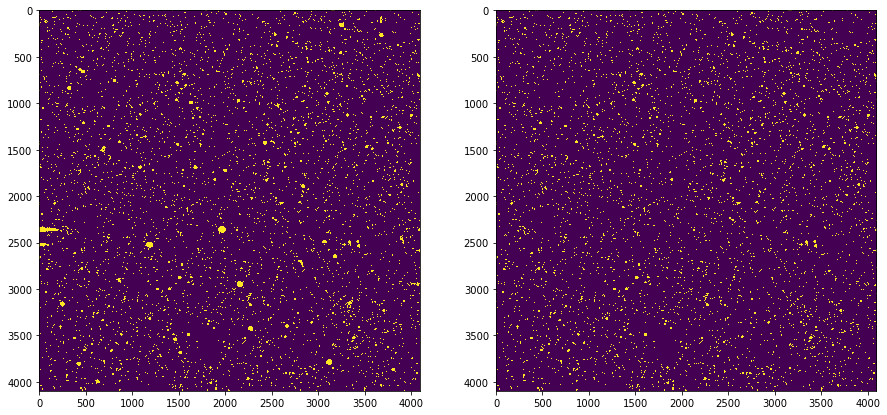

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 15)
axs[0].imshow(pa1.clustered_data > 0)
axs[1].imshow(pa1.clustered_filtered_by_area(2, 100_000) > 0)
None

## Perform Clustering to Find Particles

In [8]:
cluster_areas_and_heights = merge_cluster_dicts(
    pa1.get_cluster_areas(min_area=25 * pa1.area_per_pixel),
    {k: v[2] for k, v in pa1.get_cluster_heights().items()},
)

In [9]:
cluster_diameters_and_heights = merge_cluster_dicts(
    pa1.get_cluster_diameters(), {k: v[2] for k, v in pa1.get_cluster_heights().items()}
)

# Create Particle Analysis Plots

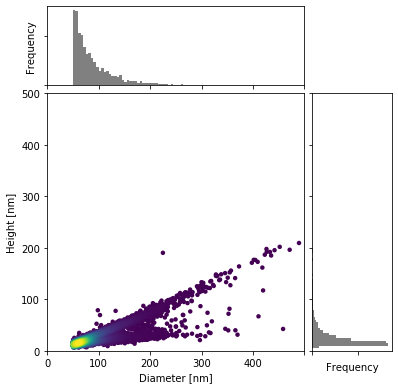

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

x = [x[0] for x in cluster_diameters_and_heights.values() if x[0] > 50]
y = [y[1] for y in cluster_diameters_and_heights.values() if y[0] > 50]

nullfmt = plt.NullFormatter()  # no labels

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(5.5, 5.5))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHistx.yaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)
axHisty.xaxis.set_major_formatter(nullfmt)
axHistx.set_ylabel("Frequency")
axHisty.set_xlabel("Frequency")


# Calculate the point density
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x = [x[i] for i in idx]
y = [y[i] for i in idx]
z = [z[i] for i in idx]

axScatter.scatter(x, y, c=z, s=20, edgecolor="")
axScatter.set_xlabel("Diameter [nm]")
axScatter.set_ylabel("Maximum Height [nm]")
axScatter.set_xlim([1, 500])
axScatter.set_ylim([1, 500])

# now determine nice limits by hand:
binwidthx = 5
xmax = np.max(x)
limx = (int(xmax / binwidthx) + 1) * binwidthx

binwidthy = 5
ymax = np.max(y)
limy = (int(ymax / binwidthy) + 1) * binwidthy

axScatter.set_xlim(0, 500)
axScatter.set_ylim((0, 500))
axScatter.set_xlabel("Diameter [nm]")
axScatter.set_ylabel("Height [nm]")
axScatter.set_xticklabels(np.arange(0, 500, 100))

binsx = np.arange(0, limx + binwidthx, binwidthx)
binsy = np.arange(0, limy + binwidthy, binwidthy)
axHistx.hist(x, bins=binsx, facecolor="grey")
axHisty.hist(y, bins=binsy, orientation="horizontal", facecolor="grey")
axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

plt.savefig('./particle_analysis_w_hist_pepHP-TD_prox_1hr.png', dpi=800)
None

In [11]:
list(cluster_diameters_and_heights.items())[:5]

[(1, (11.019327803667116, 5.260734)),
 (2, (64.25317033671426, 13.89903)),
 (3, (87.4632029508083, 31.27282)),
 (4, (143.67445664276616, 56.43443)),
 (5, (19.08603562120781, 7.55699))]

In [12]:
aspect_ratios = {
    k: (d, h, h / d) for k, (d, h) in cluster_diameters_and_heights.items() if d > 50
}

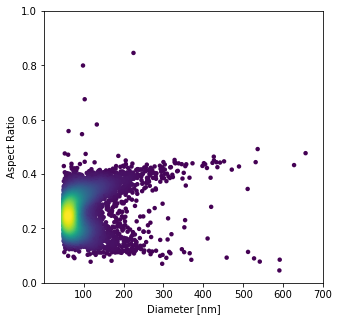

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

x = [x[0] for x in aspect_ratios.values()]
y = [y[2] for y in aspect_ratios.values()]

# Calculate the point density
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
# x, y, z = x[idx], y[idx], z[idx]
x = [x[i] for i in idx]
y = [y[i] for i in idx]
z = [z[i] for i in idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=20, edgecolor="")
ax.set_xlabel("Diameter [nm]")
ax.set_ylabel("Aspect Ratio")
ax.set_xlim([1, 700])
ax.set_ylim([0, 1])
fig.set_size_inches(5, 5, forward=True)
plt.savefig("aspect_ratio_pepHP-TD_prox_1hr", dpi=600)
None